# 3D Block -- double number of cells in each direction

=> Same as `3D-Model.ipynb`, but twice as many cells in each direction by taking half the cell size.

In [1]:
import emg3d
import empymod
import discretize
import pymatsolver
import numpy as np
import SimPEG, SimPEG.electromagnetics
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

---

# (A) Model

In [3]:
# Resistivities
res_sea = 0.3
res_bg = 1.0
res_tg = 100.0

# Seafloor
seafloor = -2000

# Target dimension
tg_x = [450, 1550]
tg_y = [-500, 500]
tg_z = [-2700, -2300]

---
# (B) Survey

In [4]:
# Source: 100 m x-directed diplole at the origin,
# 50 m above seafloor, src [x1, x2, y1, y2, z1, z2]
src = [-50, 50, 0, 0, -1950, -1950]

# Receiver: x-directed dipole at 2 km on the
# seafloor, rec = [x, y, z, azimuth, dip]
rec = [2000, 0, -2000, 0, 0]

# Times to compute, 0.1 - 10 s, 301 steps
times = np.logspace(-1, 1, 301)

---
# (C) Modelling parameters

### Time-steps (for TDEM computation with SimPEG)

In [5]:
# Time steps
time_steps = [1e-1, (1e-2, 21), (3e-2, 23), (1e-1, 21), (3e-1, 23)]

## Create mesh (`discretize`)

In [6]:
# Cell width, number of cells
width = 50
nx = rec[0]//width+8
ny = 20
nz = 18

# Padding
npadx = 28
npadyz = 24

# Stretching
alpha = 1.15

# Initiate TensorMesh
mesh = discretize.TensorMesh(
    [[(width, npadx, -alpha), (width, nx), (width, npadx, alpha)],
     [(width, npadyz, -alpha), (width, ny), (width, npadyz, alpha)],
     [(width, npadyz, -alpha), (width, nz), (width, npadyz, alpha)]],
    x0='CCC',
)

# Shift mesh so that
# x=0 is at midpoint of source;
# z=-2000 is at source/receiver level
mesh.x0[0] += rec[0]//2-width/2
mesh.x0[2] -= nz/2*width - seafloor

mesh

TensorMesh: 466,752 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    104    -19,033.48     20,983.48     50.00  2,503.28    1.15
   y     68    -11,089.65     11,089.65     50.00  1,431.26    1.15
   z     66    -13,489.65      8,589.65     50.00  1,431.26    1.15

## Put model on mesh

<IPython.core.display.Javascript object>


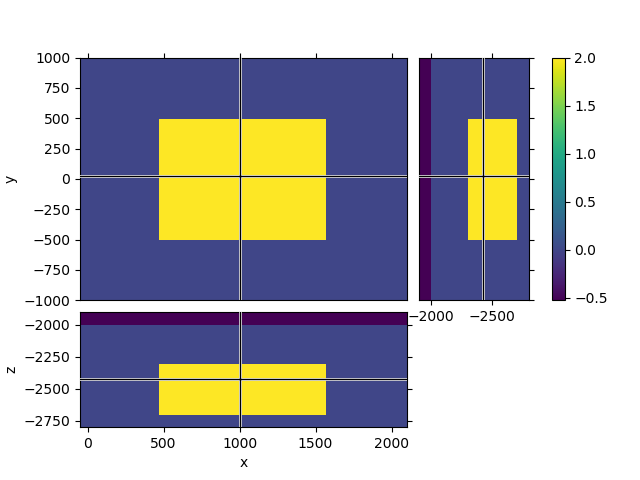

In [7]:
mres_bg = np.ones(mesh.nC)*res_sea
mres_bg[mesh.gridCC[:, 2] < seafloor] = res_bg

mres_tg = mres_bg.copy()
target_inds = (
    (mesh.gridCC[:, 0] >= tg_x[0]) & (mesh.gridCC[:, 0] <= tg_x[1]) &
    (mesh.gridCC[:, 1] >= tg_y[0]) & (mesh.gridCC[:, 1] <= tg_y[1]) &
    (mesh.gridCC[:, 2] >= tg_z[0]) & (mesh.gridCC[:, 2] <= tg_z[1])
)
mres_tg[target_inds] = res_tg

# QC.
mesh.plot_3d_slicer(
    np.log10(mres_tg), clim=[np.log10(res_sea), np.log10(res_tg)],
    xlim=[-src[0]-100, rec[0]+100], ylim=[-rec[0]/2, rec[0]/2], zlim=[tg_z[0]-100, seafloor+100],
)

---
# (D) `empymod`


Compute the 1D background semi-analytically, using 5 points to approximate the 100-m long dipole.

In [8]:
inp = {
    'src': src.copy(),
    'rec': rec.copy(),
    'depth': seafloor,
    'res': [res_sea, res_bg],
    'freqtime': times,
    'signal': -1,   # Switch-off
    'srcpts': 5,    # 5 points for finite length approx
    'strength': 1,  # Account for source length
    'verb': 1,
}

epm_bg = empymod.bipole(**inp)

---
# (E) `SimPEG`

Set-up SimPEG-specific parameters.

In [9]:
# Set up the receiver list
rec_list = [
    SimPEG.electromagnetics.time_domain.receivers.Point_e(
        orientation='x',
        times=times,
        locs=np.array([[*rec[:3]], ]),
    ),
]


# Set up the source list
src_list = [
    SimPEG.electromagnetics.time_domain.sources.LineCurrent(
        rxList=rec_list,
        loc=np.array([[*src[::2]], [*src[1::2]]]),
    ),
]


# Create `Survey`
survey = SimPEG.electromagnetics.time_domain.Survey(src_list)

# Define the `Simulation`
sim = SimPEG.electromagnetics.time_domain.simulation.Simulation3DElectricField(
    mesh,
    survey=survey,
    rhoMap=SimPEG.maps.IdentityMap(mesh),
    Solver=pymatsolver.Pardiso,
    timeSteps=time_steps,
)

### Compute

In [10]:
%%time
spg_bg = sim.dpred(mres_bg)
spg_tg = sim.dpred(mres_tg)

CPU times: user 1d 1h 31min 50s, sys: 22min 15s, total: 1d 1h 54min 5s
Wall time: 1h 7min 12s


---
# (F) `emg3d`

### Fourier-transform and Model instances

In [11]:
# We use the frequency range as given by the FFTLog
F = emg3d.utils.Fourier(
    time=times,
    fmin=0.001,
    fmax=10,
    signal=-1,
    ft='fftlog',
    ftarg={'pts_per_dec': 5},
)

print("\n---\n")

# But for the actual transform, we use DLF
Fourier = emg3d.utils.Fourier(
    time=F.time,
    fmin=F.fmin,
    fmax=F.fmax,
    signal=F.signal,
    ft='dlf',
    freq_inp=F.freq_calc
)

   time        [s] :  0.1 - 10 : 301  [min-max; #]
   Fourier         :  FFTLog
     > pts_per_dec :  5
     > add_dec     :  [-2.  1.]
     > q           :  0.0
   Req. freq  [Hz] :  0.000200364 - 12.6421 : 25  [min-max; #]
   Calc. freq [Hz] :  0.00126421 - 7.97664 : 20  [min-max; #]

---

   time        [s] :  0.1 - 10 : 301  [min-max; #]
   Fourier         :  DLF (Cosine-Filter)
     > Filter      :  Key 201 CosSin (2012)
     > DLF type    :  Lagged Convolution
   Req. freq  [Hz] :  1.4626E-08 - 1.95429E+06 : 235  [min-max; #]
   Calc. freq [Hz] :  0.00126421 - 7.97664 : 20  [min-max; #]


In [12]:
# Geneal input for the emg3d-solver
sinp = {'verb': -1, 'sslsolver': True, 'semicoarsening': True, 'linerelaxation': True}

# General input for gridding
gridinput = {
    'min_width': 50,      # Fix the cell width within the survey domain to 100 m.
    'max_domain': 30000,
    'verb': 0,
    'alpha': [1, 1.2, 0.01],
}

# Define Model instances for the two models
model_bg_orig = emg3d.utils.Model(mesh, mres_bg)
model_tg_orig = emg3d.utils.Model(mesh, mres_tg)

# Pre-allocate data
data_bg = np.zeros(Fourier.freq_calc.size, dtype=complex)
data_tg = np.zeros(Fourier.freq_calc.size, dtype=complex)

### Compute

In [13]:
%%time

# Loop over frequencies, going from high to low.
for fi, frq in enumerate(Fourier.freq_calc[::-1]):
    print(f"=> {fi+1:2}/{Fourier.freq_calc.size} :: {frq:10.6f} Hz; #cells: ", end='')

    # Get cell widths and origin in each direction
    xx, x0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1], fixed=src[0], domain=[-100, 2100], **gridinput)
    yy, y0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1], fixed=0, domain=[-500, 500], **gridinput)
    zz, z0 = emg3d.utils.get_hx_h0(
        freq=frq, res=[0.3, 1.], domain=[-2800, -1900], **gridinput, fixed=[-2300, -2000, -2700])

    # Initiate mesh.
    grid = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
    print(grid.nC)

    # Interpolate the starting electric field from the last one
    # (can speed-up the computation).
    if fi == 0:
        efield = emg3d.utils.Field(grid, freq=frq)
    else:
        efield = emg3d.utils.grid2grid(
            old_grid, efield, grid, method='cubic', extrapolate=False)
        efield = emg3d.utils.Field(grid, efield, freq=frq)
    
    # Put model on mesh
    res_x_bg = emg3d.utils.grid2grid(mesh, model_bg_orig.res_x, grid, 'volume', log=True)
    res_x_tg = emg3d.utils.grid2grid(mesh, model_tg_orig.res_x, grid, 'volume', log=True)
    model_bg = emg3d.utils.Model(grid, res_x_bg)
    model_tg = emg3d.utils.Model(grid, res_x_tg)

    # Define source.
    sfield = emg3d.utils.get_source_field(grid, [*src], frq, strength=1)

    # Solve the system.
    efield_bg = emg3d.solve(grid, model_bg, sfield, **sinp)
    efield_tg = emg3d.solve(grid, model_tg, sfield, **sinp)

    # Get response at receiver
    data_bg[fi] = emg3d.utils.get_receiver(grid, efield_bg.fx, (rec[0], rec[1], rec[2]))
    data_tg[fi] = emg3d.utils.get_receiver(grid, efield_tg.fx, (rec[0], rec[1], rec[2]))

    # Store the grid for the interpolation.
    old_grid = grid

=>  1/20 ::   7.976643 Hz; #cells: 102400
:: emg3d :: 4.8e-07; 1(3); 0:00:06; CONVERGED
:: emg3d :: 5.5e-07; 1(3); 0:00:06; CONVERGED
=>  2/20 ::   5.032921 Hz; #cells: 102400
:: emg3d :: 1.0e-06; 1(3); 0:00:06; CONVERGED
:: emg3d :: 6.7e-08; 1(4); 0:00:08; CONVERGED
=>  3/20 ::   3.175559 Hz; #cells: 102400
:: emg3d :: 1.2e-07; 1(4); 0:00:08; CONVERGED
:: emg3d :: 2.2e-07; 1(4); 0:00:07; CONVERGED
=>  4/20 ::   2.003642 Hz; #cells: 184320
:: emg3d :: 4.0e-07; 1(4); 0:00:14; CONVERGED
:: emg3d :: 2.6e-07; 1(4); 0:00:14; CONVERGED
=>  5/20 ::   1.264213 Hz; #cells: 184320
:: emg3d :: 1.4e-07; 1(5); 0:00:17; CONVERGED
:: emg3d :: 9.7e-07; 1(4); 0:00:14; CONVERGED
=>  6/20 ::   0.797664 Hz; #cells: 184320
:: emg3d :: 4.7e-07; 1(5); 0:00:17; CONVERGED
:: emg3d :: 5.0e-07; 1(5); 0:00:17; CONVERGED
=>  7/20 ::   0.503292 Hz; #cells: 245760
:: emg3d :: 6.7e-08; 1(6); 0:00:28; CONVERGED
:: emg3d :: 7.3e-08; 1(6); 0:00:28; CONVERGED
=>  8/20 ::   0.317556 Hz; #cells: 327680
:: emg3d :: 1.9e-07;

### Fourier transform

In [14]:
egd_bg = Fourier.freq2time(data_bg[::-1], rec[0])
egd_tg = Fourier.freq2time(data_tg[::-1], rec[0])

---
# (G) Plots

<IPython.core.display.Javascript object>


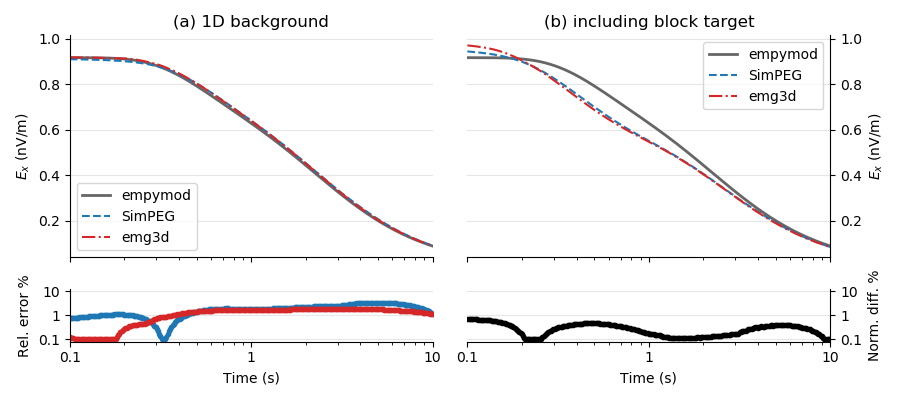

In [15]:
plt.figure(figsize=(9, 4))

# # # Plot Responses  # # #
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=3)
plt.title('(a) 1D background')

plt.plot(times, epm_bg*1e9, '.4', lw=2, label='empymod')

plt.plot(times, spg_bg*1e9, 'C0--', label='SimPEG')
plt.plot(times, egd_bg*1e9, 'C3-.', label='emg3d')

plt.ylabel('$E_x$ (nV/m)')
plt.xscale('log')
plt.xlim([0.1, 10])
ax1.set_xticklabels([])
plt.legend(loc=3)
plt.grid(axis='y', c='0.9')


# # # Plot Relative Error (%) # # #
ax2 = plt.subplot2grid((4, 2), (3, 0))

err_spg = np.clip(100*abs((epm_bg-spg_bg)/epm_bg), 0.1, 10)
err_egd = np.clip(100*abs((epm_bg-egd_bg)/epm_bg), 0.1, 10)

plt.plot(times, err_spg, 'C0.')
plt.plot(times, err_egd, 'C3.')

plt.xscale('log')
plt.yscale('log')
plt.xlim(ax1.get_xlim())
plt.ylabel('Rel. error %')
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.xticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.grid(axis='y', c='0.9')
plt.xlabel('Time (s)')


# # # Plot target model # # #
ax3 = plt.subplot2grid((4, 2), (0, 1), rowspan=3, sharey=ax1)
plt.title('(b) including block target')

plt.plot(times, epm_bg*1e9, '.4', lw=2, label='empymod')

plt.plot(times, spg_tg*1e9, 'C0--', label='SimPEG')
plt.plot(times, egd_tg*1e9, 'C3-.', label='emg3d')

plt.xlim([0.1, 10])
#plt.yscale('log')
plt.xscale('log')
plt.ylabel('$E_x$ (nV/m)')
ax3.set_xticklabels([])
plt.legend()
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')


# # # Normalized Difference # # #
ax4 = plt.subplot2grid((4, 2), (3, 1))

norm_diff = np.clip(200*abs(egd_tg-spg_tg)/(abs(egd_tg)+abs(spg_tg)), 0.1, 10)
plt.plot(times, norm_diff, 'k.')

plt.xscale('log')
plt.yscale('log')
plt.xlim(ax1.get_xlim())
plt.xlabel('Time (s)')
plt.ylabel('Norm. diff. %')
plt.ylim([8e-2, 12])
plt.yticks([0.1, 1, 10], ('0.1', '1', '10'))
plt.xticks([0.1, 1, 10], ('0.1', '1', '10'))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
plt.grid(axis='y', c='0.9')

# Switch off spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

In [16]:
empymod.Report([emg3d, SimPEG, discretize])

--------------------------------------------------------------------------------
  Date: Mon Jun 22 18:17:21 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GB
       Environment : Jupyter

  Python 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20)
  [GCC 7.3.0]

             emg3d : 0.11.1.dev15+g0edde7f
            SimPEG : 0.14.1
        discretize : 0.4.12
             numpy : 1.18.5
             scipy : 1.4.1
             numba : 0.49.1
           empymod : 2.0.1
           IPython : 7.15.0
        matplotlib : 3.2.2
--------------------------------------------------------------------------------